### Sustainability Aware Asset Management: **Groupe A: North America // Scope 1 + 2**
#### **Part I - Standard Asset Allocation**

In [2]:
## Packages lists:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.3)
import datetime as dt
from scipy.optimize import minimize

## Importing all the dataframes from data.ipynb
%run data.ipynb

0
595


In [3]:
## Converting into returns using the simple return definition. Also replacing the NaN in the first period by 0.
df_m = monthly_return.pct_change()
monthly_means = df_m.iloc[1:].mean()
df_m.fillna(monthly_means, inplace=True)
df_m.index = pd.to_datetime(df_m.index)

df_y = yearly_return.pct_change()
yearly_means = df_y.iloc[1:].mean()
df_y.fillna(yearly_means, inplace=True)

In [4]:
## DataFrame monthly returns
df_m.head()

,SCHLUMBERGER,ARCH CAP.GP.,EVEREST GROUP,NABORS INDUSTRIES,RENAISSANCERE HDG.,SIGNET JEWELERS,WHITE MOUNTAINS IN.GP.,ARC RESOURCES,AGNICO-EAGLE MNS. (NYS),ALIMENTATION COUCHE TARD,...,WHIRLPOOL,JOHN WILEY AND SONS A,WILLIAMS,WILLIAMS-SONOMA,WOLFSPEED,XCEL ENERGY,XEROX HOLDINGS,YUM! BRANDS,ZEBRA TECHNOLOGIES 'A',ZIONS BANCORP.
2000-01-31,0.009426,0.015105,0.012965,0.012864,0.012923,0.018358,0.012095,0.014740,0.017098,0.021781,...,0.011358,0.007683,0.011675,0.015654,0.015167,0.010854,0.004935,0.015523,0.013134,0.006157
2000-02-29,0.213043,0.042720,-0.024785,0.210970,-0.024188,-0.123221,-0.020000,-0.018121,0.090446,-0.054018,...,-0.061660,-0.050000,0.072112,-0.023672,0.996015,-0.087661,0.041931,-0.069851,0.124601,-0.102536
2000-03-31,0.035756,0.073857,0.331254,0.081883,0.083020,0.065703,0.220886,0.028631,-0.205356,0.017976,...,0.079406,0.265912,0.054242,0.002025,-0.399201,0.131676,0.206472,0.166608,-0.248818,-0.215549
2000-04-30,0.000814,-0.060083,-0.103420,0.016102,-0.098173,0.081647,0.036805,0.035981,-0.033699,0.051096,...,0.110870,-0.041666,-0.146517,0.116935,0.289036,0.116712,0.019246,0.090519,0.139995,-0.003003
2000-05-31,-0.039184,-0.025404,0.162378,0.090333,0.182463,-0.159331,0.015288,0.113836,0.000000,-0.077749,...,-0.125011,0.032612,0.108336,-0.074007,-0.165056,0.014328,0.031131,-0.134621,-0.157894,0.128942


### Part I - Standard Asset Allocation

#### 1.1 - Construction of a minimum variance portfolio

As we are computing the minimum variance portfolio out-of-sample, we use the first 6 years of monthly returns (from Jan. 2000 to Dec. 2005) to compute the vector of expected returns and the covariance matrix

In [5]:
## Sampling the dataframe from Jan. 2000 to Dec. 2005
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)
stocks = df_m.columns
sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]

## Checking if tau is equal to 72
tau = len(sample_m)
tau == 72

True

We computed the expected returns as:
$$
\hat{\mu}_{Y+1} = \frac{1}{\tau}\sum_{k=0}^{\tau-1} R_{t-k}
$$

In [6]:
## It is simply a basic mean function.
mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T

The covariance matrix is computed as:
$$
\Sigma_{Y+1} = \frac{1}{\tau}\sum_{k=0}^{\tau-1} (R_{t-k} - \hat{\mu}_{Y+1})'(R_{t-k} - \hat{\mu}_{Y+1})
$$

In [7]:
## We use the parameter bias=True, because we divide the sum by 1/tau instead of 1/(tau-1)
excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
covmat = 1/tau * excess_returns.T @ excess_returns

## We control if there is a missing value in our covariance matrix
print(covmat.isnull().values.any())

False


For the allocation, we use the following maximizazion problem, while restricting the optimal weights to be positive:

$$\min_{{{\alpha_{Y}}}}\quad \sigma^{2}_{p,Y+1} = \alpha'_{Y}\Sigma_{Y+1}\alpha_{Y}$$

$$\text{s.t.}\quad \alpha'_{Y}e = 1$$

$$\text{s.t.}\quad  \alpha_{i,Y} \ge 0 \quad \text{for all i}$$

In [8]:
# Define objective function (portfolio variance)
def portfolio_variance(weights, covmat):
    return np.dot(weights.T, np.dot(covmat, weights))

# Define constraint (sum of weights equals 1)
def constraint(weights):
    return np.sum(weights) - 1
    
# Number of assets
n_assets = len(covmat)

# Initial guess for weights
initial_weights = np.ones(n_assets) / n_assets

# Define bounds for weights (0 to 1) long-only portfolio
bounds = [(0, None)] * n_assets

# Perform optimization
result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': constraint}, bounds=bounds)

# Get optimal weights
optimal_weights = result.x

# Print results
weights = pd.DataFrame(optimal_weights, index=covmat.index, columns=['weight'])
weights

,weight
SCHLUMBERGER,0.000000e+00
ARCH CAP.GP.,1.108019e-18
EVEREST GROUP,1.248343e-19
NABORS INDUSTRIES,8.393561e-19
RENAISSANCERE HDG.,1.219385e-02
...,...
XCEL ENERGY,9.074212e-20
XEROX HOLDINGS,0.000000e+00
YUM! BRANDS,5.808223e-04
ZEBRA TECHNOLOGIES 'A',2.075877e-03


In [9]:
## These are the 20 largest weights of the min variance portfolio 2006 using out of sample data: 2000-2005
weights['weight'].nlargest(20)

HERSHEY                    0.080769
SOUTHERN                   0.057619
MEDTRONIC                  0.054424
BLACKROCK                  0.052931
VALHI                      0.041819
PUBLIC STORAGE             0.039619
LOCKHEED MARTIN            0.035474
PROCTER & GAMBLE           0.033998
AGNICO-EAGLE MNS. (NYS)    0.033846
IMPERIAL OIL               0.033091
BOSTON SCIENTIFIC          0.032089
BALL                       0.030862
MARKEL GROUP               0.029572
HUNTINGTON BCSH.           0.029023
IDEXX LABORATORIES         0.028369
RB GLOBAL (NYS)            0.028322
UNITED THERAPEUTICS        0.022599
BCE                        0.021846
VIATRIS                    0.020589
GEN DIGITAL                0.019220
Name: weight, dtype: float64

## Rebalance portfolio from Dec. 2005 to Dec. 2021. (We start to use the rolling windows here)

In [10]:
def roll_min_var_opt(df, start, end):
    stocks = df.columns
    year_weight = end.year + 1
    weights_df = pd.DataFrame(index=stocks)

    for i in range(18):
        ## Resample from start to end
        sample_m = df[df.index.isin(pd.date_range(start, end))]
        tau = len(sample_m)

        ## Compute expected returns
        mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    
        ## Excess returns
        excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    
        ## Covariance Matrix
        covmat = 1/tau * excess_returns.T @ excess_returns
    
        # Define objective function (portfolio variance)
        def portfolio_variance(weights, covmat):
            return np.dot(weights.T, np.dot(covmat, weights))
    
        # Define constraint (sum of weights equals 1)
        def constraint(weights):
            return np.sum(weights) - 1
    
        n_assets = len(covmat)
    
        # Initial guess for weights
        initial_weights = np.ones(n_assets) / n_assets
        
        # Define bounds for weights (0 to 1) long-only portfolio
        bounds = [(0, None)] * n_assets
    
        result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': constraint}, bounds=bounds)
    
        optimal_weights = result.x

        weights_df[year_weight] = optimal_weights

        start = dt.datetime(start.year + 1, 1, 1)
        end = dt.datetime(end.year + 1, 1, 1)
        year_weight += 1

    return weights_df

In [11]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)

weights_df = roll_min_var_opt(df_m, start, end)

In [12]:
## These are the optimal weights for each year using rolling window 
## (e.g. for 2006, data used is 2000-2005. For 2007, data used is 2001-2006)
weights_df.head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
SCHLUMBERGER,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.689575e-18,1.465499e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.491707e-18,0.000000e+00,0.000000e+00,0.000000,0.000000,2.604964e-19,3.860986e-18,2.956129e-18
ARCH CAP.GP.,1.108019e-18,0.000000e+00,3.733631e-18,0.000000e+00,2.162207e-18,3.404186e-18,1.014346e-02,1.834554e-17,0.000000e+00,0.000000e+00,0.000000e+00,2.123814e-18,6.580794e-18,0.001013,0.001145,9.366200e-18,0.000000e+00,3.864535e-18
EVEREST GROUP,1.248343e-19,2.694298e-18,2.094859e-18,0.000000e+00,0.000000e+00,0.000000e+00,2.076406e-04,1.635417e-18,0.000000e+00,3.121960e-03,0.000000e+00,0.000000e+00,9.010329e-03,0.002662,0.044626,6.702413e-02,2.534687e-02,2.804996e-02
NABORS INDUSTRIES,8.393561e-19,0.000000e+00,2.856289e-19,1.148077e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.231401e-18,1.323672e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,9.811715e-19,3.444937e-18,2.657304e-19
RENAISSANCERE HDG.,1.219385e-02,1.824573e-02,2.294535e-02,0.000000e+00,0.000000e+00,5.094555e-18,1.032211e-17,1.181809e-17,0.000000e+00,3.260270e-02,1.938555e-02,3.693503e-03,9.341518e-03,0.003801,0.012310,3.082429e-02,3.846325e-03,9.930473e-03


In [13]:
## Just computing 5 largest of each column
n_largest_per_year = {}  

for year in weights_df.columns:
    # Get the 5 largest values for the column
    n_largest_per_year[year] = weights_df[year].nlargest(5)

In [14]:
## 5 largest weights for each year
n_largest_per_year

{2006: HERSHEY      0.080769
 SOUTHERN     0.057619
 MEDTRONIC    0.054424
 BLACKROCK    0.052931
 VALHI        0.041819
 Name: 2006, dtype: float64,
 2007: HERSHEY            0.066213
 MEDTRONIC          0.045116
 LOCKHEED MARTIN    0.040563
 BLACKROCK          0.039918
 GENERAL MILLS      0.038842
 Name: 2007, dtype: float64,
 2008: BCE              0.056685
 MEDTRONIC        0.053973
 GENERAL MILLS    0.052675
 HERSHEY          0.049359
 STERICYCLE       0.045265
 Name: 2008, dtype: float64,
 2009: MEDTRONIC            0.055181
 WALMART              0.049446
 PPL                  0.046926
 JOHNSON & JOHNSON    0.039326
 STERICYCLE           0.037457
 Name: 2009, dtype: float64,
 2010: WALMART                0.088647
 QUEST DIAGNOSTICS      0.063039
 STRATEGIC EDUCATION    0.061231
 W R BERKLEY            0.059498
 GENERAL MILLS          0.049377
 Name: 2010, dtype: float64,
 2011: WALMART                 0.133318
 HORMEL FOODS            0.080798
 STRATEGIC EDUCATION     0.075028
 Q

In [15]:
## Checking if the first constraint is respected.
weights_df.sum()

2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
2023    1.0
dtype: float64

In [16]:
## Checking if the second constraint is respected.
print('The smallest weight is: ', np.min(weights_df))
print('The highest weight is: ', np.max(weights_df))

The smallest weight is:  0.0
The highest weight is:  0.15300345824024333


## Ex-post performance computation

In [17]:
debut = dt.date(2005,12,31)
fin = dt.date(2022,12,31)

sample_returns = df_m[df_m.index.isin(pd.date_range(debut, fin))]
weights_sample = pd.DataFrame(columns=sample_returns.index, index=sample_returns.columns)

## replace all the weights of December N-1 by the weights in the weights_df
for i in range(weights_sample.shape[1]):
    if weights_sample.columns[i].month == 12:
        weights_sample.iloc[:,i] = weights_df[weights_sample.columns[i].year + 1]

In [18]:
year = 2006
debut1 = dt.date(year, 1,1)
fin1 = dt.date(year, 12, 31)

## Returns of each stock between debut1 and fin1
sample_returns = df_m[df_m.index.isin(pd.date_range(debut1, fin1))].T

## alphas between December Y-1 and November Y
test = weights_sample.iloc[:,weights_sample.columns.year == year].iloc[: , :-1]
test.insert(0, dt.date(year-1,12,31), weights_df[year])

In [19]:
## DataFrame of the alphas
alpha_data = pd.DataFrame()

for x in range(2006,2023):
    year = x
    debut1 = dt.date(year, 1,1)
    fin1 = dt.date(year, 12, 31)

    sample_returns = df_m[df_m.index.isin(pd.date_range(debut1, fin1))].T
    test = weights_sample.iloc[:,weights_sample.columns.year == year].iloc[: , :-1]
    test.insert(0, dt.date(year-1,12,31), weights_df[year])
    
    for j in range(1,12):
        for i in range(595):
            x = sample_returns.iloc[i,j-1] ## STOCK, DATE
            y = test.iloc[:,j-1] @ sample_returns.iloc[:,j-1] ## January 2006 Performance
            previous_a = test.iloc[i,j-1] ## STOCK, DATE
            
            new_a = previous_a * ((1+x)/(1+y))
            test.iloc[i,j] = new_a

    alpha_data = pd.concat([alpha_data, test], axis=1)

alpha_data = alpha_data.T
alpha_data.index = pd.to_datetime(alpha_data.index)
alpha_data = alpha_data.T

In [20]:
## Ex-post performance calculation
debut2 = dt.date(2006,1,1)
fin2 = dt.date(2022,12,31)
returns06_22 = df_m[df_m.index.isin(pd.date_range(debut2, fin2))].T

performances = []

for i in range(returns06_22.shape[1]):
    performance = returns06_22.iloc[:,i] @ alpha_data.iloc[:,i]
    performances.append(performance)

performances = pd.DataFrame(performances, columns=['performance'], index=returns06_22.columns).T

### Compute the characteristics of this portfolio over the sample: annualized average return ($\bar{\mu}_{p}$), annualized volatility $(\sigma_{p})$, Sharpe ratio $(SR_{p})$, minimum, maximum, and maximum drawdown.

In [21]:
def portfolio_characteristics(performances, portfolio_name):
    averagereturn = performances.mean()
    ann_averagereturn = (12 * averagereturn)

    sigma_m = (1/len(performances) * np.sum(performances.subtract(averagereturn) ** 2)) ** (1/2)
    sigma_y = np.sqrt(12) * sigma_m

    rf = risk_free/100
    rf = rf[rf.index.isin(performances.index)]

    sharpe_m = (performances.subtract(rf.values.squeeze()).mean()/sigma_m).mean()
    sharpe_y = (np.sqrt(12) * sharpe_m)

    minimum = np.min(performances)
    maximum = np.max(performances)

    cum_ret = (1+performances).cumprod()
    peaks = cum_ret.cummax()
    drawdowns = (cum_ret - peaks) / peaks
    MDD = drawdowns.min()

    dataframe = pd.DataFrame(index=['Annualized Average Return', 'Annualized Volatility', 'Sharpe Ratio', 'Minimum', 'Maximum', 'Maximum Drawdown'], columns=[portfolio_name])
    dataframe.iloc[0,0] = ann_averagereturn
    dataframe.iloc[1,0] = sigma_y
    dataframe.iloc[2,0] = sharpe_y
    dataframe.iloc[3,0] = minimum
    dataframe.iloc[4,0] = maximum
    dataframe.iloc[5,0] = MDD

    return dataframe

In [22]:
portfolio_mv = portfolio_characteristics(performances.squeeze(), 'Portfolio MV')
portfolio_mv

,Portfolio MV
Annualized Average Return,0.105873
Annualized Volatility,0.131705
Sharpe Ratio,0.723517
Minimum,-0.156537
Maximum,0.106319
Maximum Drawdown,-0.36387


#### 1.2 - Comparison with the benchmark, the value-weighted portfolio $P^{(vw)}$

$$
R_{t+1}^{(vw)} = \sum^{N}_{i=1}w_{i,t}R_{i,t+1}
$$

$$
w_{i,t} = \frac{Cap_{i,t}}{\sum^{N}_{j=1}Cap_{j,t}}
$$

In [23]:
## Total Market Cap of All Stocks
mvdf = mv.copy()
totalcap = mvdf.sum()

## Weights of each stock using the second formula
mv_weights = mvdf.div(totalcap)

## Resampling both from 2006 to 2022.
debut_weights = dt.date(2005,12,31)
fin_weights = dt.date(2022,11,30)

debut_returns = dt.date(2006,1,1)
fin_returns = dt.date(2022,12,31)


mv_ret = df_m[df_m.index.isin(pd.date_range(debut_returns, fin_returns))].T
mv_weights = mv_weights.T[mv_weights.T.index.isin(pd.date_range(debut_weights, fin_weights))].T

In [24]:
mv_perf = []

for i in range(mv_ret.shape[1]):
    x = mv_weights.iloc[:,i] @ mv_ret.iloc[:,i]
    mv_perf.append(x)

mv_perf = pd.DataFrame(mv_perf, index=mv_ret.columns, columns=['Return'])

In [25]:
portfolio_vw = portfolio_characteristics(mv_perf.squeeze(), 'Portfolio VW')
portfolio_vw

,Portfolio VW
Annualized Average Return,0.103492
Annualized Volatility,0.15219
Sharpe Ratio,0.610482
Minimum,-0.168004
Maximum,0.124161
Maximum Drawdown,-0.478136


#### Comparison between Portfolio and Benchmark

In [26]:
pd.concat([portfolio_mv, portfolio_vw], axis=1)

,Portfolio MV,Portfolio VW
Annualized Average Return,0.105873,0.103492
Annualized Volatility,0.131705,0.15219
Sharpe Ratio,0.723517,0.610482
Minimum,-0.156537,-0.168004
Maximum,0.106319,0.124161
Maximum Drawdown,-0.36387,-0.478136


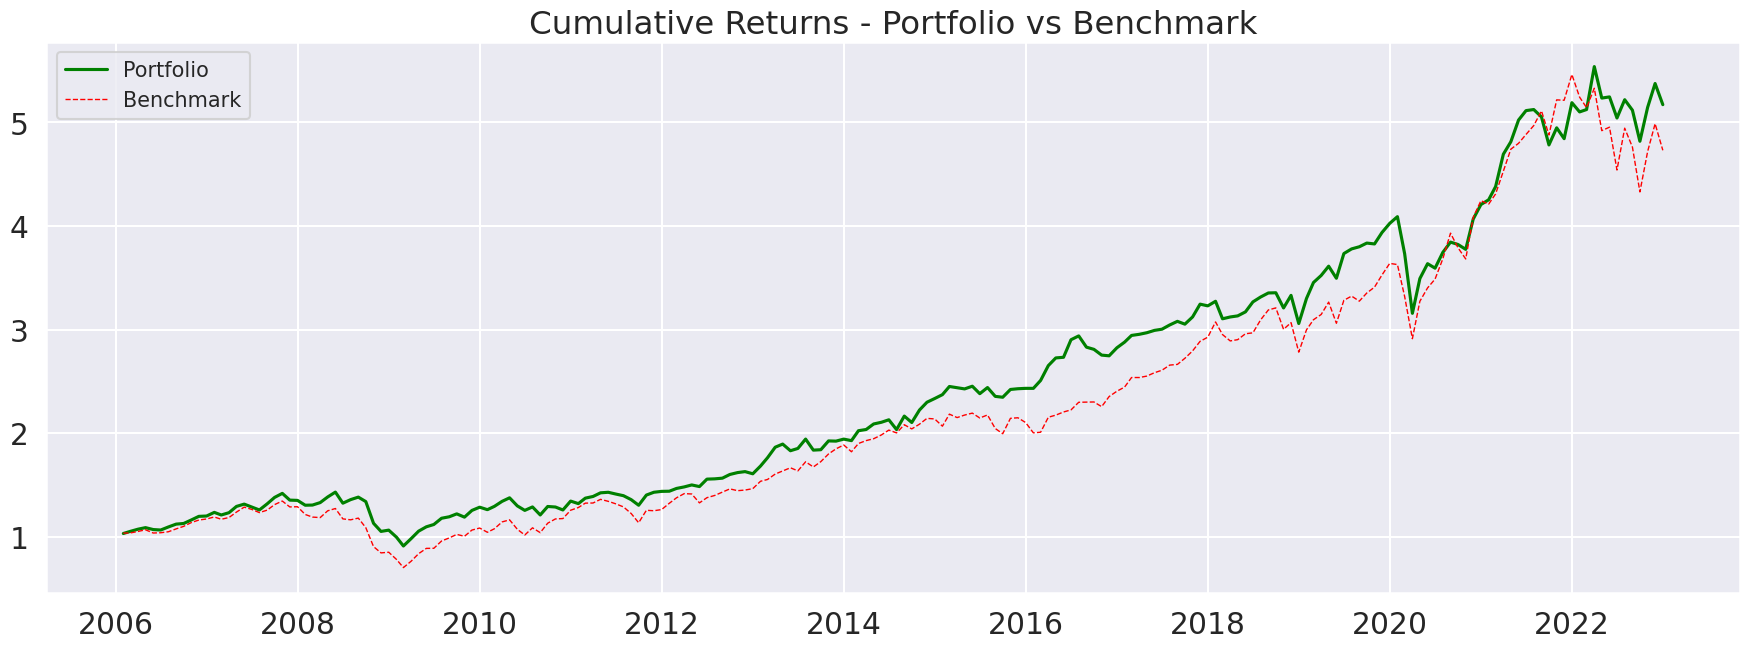

In [27]:
fig, ax = plt.subplots(figsize=(18,7))

ax.title.set_text('Cumulative Returns - Portfolio vs Benchmark')
ax.plot((1+performances.T).cumprod(), color='green', label="Portfolio")
ax.plot((1+mv_perf).cumprod(), color='red', label="Benchmark", lw = 1, linestyle='--')
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()

#### **Part 2 - Asset Allocation with a Carbon Emissions Reduction**

##### 2. Allocation with a 50% Reduction in Carbon Emissions

In [28]:
scope1_int = pd.read_excel('Data/TC_Scope1Intensity.xlsx', index_col=0)
scope1_int = scope1_int[scope1_int.index.isin(companies.index)].reset_index().set_index('NAME')
scope1_int = scope1_int.iloc[:,7:]

scope1_em = pd.read_excel('Data/TC_Scope1.xlsx', index_col=0)
scope1_em = scope1_em[scope1_em.index.isin(companies.index)].reset_index().set_index('NAME')
scope1_em = scope1_em.iloc[:,7:]

scope2_int = pd.read_excel('Data/TC_Scope2Intensity.xlsx', index_col=0)
scope2_int = scope2_int[scope2_int.index.isin(companies.index)].reset_index().set_index('NAME')
scope2_int = scope2_int.iloc[:,7:]

scope2_em = pd.read_excel('Data/TC_Scope2.xlsx', index_col=0)
scope2_em = scope2_em[scope2_em.index.isin(companies.index)].reset_index().set_index('NAME')
scope2_em = scope2_em.iloc[:,7:]

carbon_em = scope2_em + scope1_em
carbon_int = scope2_int + scope1_int

In [29]:
'''
We can see elow that we have some missing values for 2005 and 2014.

In 2005, we have missing values for the companies:
    * AMERICA S CAR MART
    * APOGEE ENTERPRISES
    * EAGLE MATERIALS
    * RITE AID

In 2014, we have missing values for the company:
    * SUNOPTA (NAS)
'''
print("================== Carbon Intensity - Missing Values ==================")
print(carbon_int.isna().any())
print("================== 2005 ==================")
print(carbon_int.T.loc[2005][carbon_int.T.loc[2005].isna()])
print("================== 2014 ==================")
print(carbon_int.T.loc[2014][carbon_int.T.loc[2014].isna()])

================== Carbon Intensity - Missing Values ==================
2005     True
2006    False
2007    False
2008    False
2009    False
2010    False
2011    False
2012    False
2013    False
2014     True
2015    False
2016    False
2017    False
2018    False
2019    False
2020    False
2021    False
dtype: bool
================== 2005 ==================
NAME
AMERICA S CAR MART   NaN
APOGEE ENTERPRISES   NaN
EAGLE MATERIALS      NaN
RITE AID             NaN
Name: 2005, dtype: float64
================== 2014 ==================
NAME
SUNOPTA (NAS)   NaN
Name: 2014, dtype: float64


In [30]:
'''
We can see elow that we have some missing values for 2005 and 2014.

In 2005, we have missing values for the companies:
    * AMERICA S CAR MART
    * APOGEE ENTERPRISES
    * EAGLE MATERIALS
    * RITE AID

In 2014, we have missing values for the company:
    * SUNOPTA (NAS)
'''
print("================== Carbon Emissions - Missing Values ==================")
print(carbon_em.isna().any())
print("================== 2005 ==================")
print(carbon_em.T.loc[2005][carbon_em.T.loc[2005].isna()])
print("================== 2014 ==================")
print(carbon_em.T.loc[2014][carbon_em.T.loc[2014].isna()])

================== Carbon Emissions - Missing Values ==================
2005     True
2006    False
2007    False
2008    False
2009    False
2010    False
2011    False
2012    False
2013    False
2014     True
2015    False
2016    False
2017    False
2018    False
2019    False
2020    False
2021    False
dtype: bool
================== 2005 ==================
NAME
AMERICA S CAR MART   NaN
APOGEE ENTERPRISES   NaN
EAGLE MATERIALS      NaN
RITE AID             NaN
Name: 2005, dtype: float64
================== 2014 ==================
NAME
SUNOPTA (NAS)   NaN
Name: 2014, dtype: float64


In [31]:
'''
2005: The choice was made to select the mean of the year 2006 to 2008 in order to
have values the are not too far from 2006. We can see that the values are quite similar.
'''
cies = ['AMERICA S CAR MART', 'APOGEE ENTERPRISES', 'EAGLE MATERIALS', 'RITE AID']
carbon_em.loc[cies, 2005] = carbon_em.loc[cies, 2006:2008].mean(axis=1)
carbon_int.loc[cies, 2005] = carbon_int.loc[cies, 2006:2008].mean(axis=1)

'''
2014: An interpolate method was selected for that.
We couldn't unfortunately use the interpolation method for 2005 as we didn't have any data before 2005.
'''
carbon_em.loc['SUNOPTA (NAS)'] = carbon_em.loc['SUNOPTA (NAS)'].interpolate()
carbon_int.loc['SUNOPTA (NAS)'] = carbon_int.loc['SUNOPTA (NAS)'].interpolate()

In [32]:
print(f'Has the carbon emission dataframe any missing values? {carbon_em.isna().any().any()}')

print(f'\nHas the carbon intensity dataframe any missing values? {carbon_int.isna().any().any()}')

Has the carbon emission dataframe any missing values? False

Has the carbon intensity dataframe any missing values? False


2.1 We compute the weighted average carbon intensity and the carbon footprint:

$$
WACI^{(P)}_{Y} = \sum^{N}_{i=1}\alpha_{i,Y}CI_{i,Y}
$$

$$
CF_{Y}^{(p)} = \sum^{N}_{i=1} o_{i,Y} E_{i,Y}
$$

In [33]:
### WACI ###
'''
Here we compute the Weighted Average Carbon Intensity (WACI) of the portfolio.
We use the weights for Y (computed as of 31.Dec Y) with the carbon intensity of Y.
'''

waci = pd.DataFrame(columns=['Carbon Intensity'], index=range(2006, 2022+1))

for year in range(2006, 2022+1):
    waci.loc[year] = (weights_df.T.loc[year] * carbon_int.T.loc[year-1]).sum()
    
waci

,Carbon Intensity
2006,721.733881
2007,445.104741
2008,640.329015
2009,638.070719
2010,488.474619
2011,214.056743
2012,301.165151
2013,617.256565
2014,480.041972
2015,728.878852


In [34]:
## Carbon Footprint

## Compute the V_{Y} (Dollar value of the Portfolio at year Y)
initial_invest = 1_000_000
vy = pd.DataFrame(index=range(2005,2022+1), columns=['Portfolio Value (in $)'])
x = (1+performances.T).cumprod() * initial_invest

for year in range(2005, 2022+1):
    if year == 2005:
        vy.loc[year] = initial_invest
    else:
        vy.loc[year] = x[x.index.year == year].iloc[-1,:].values[0]

## Compute the V_{i,Y} (Dollar value invested in firm i at year Y)

viy = pd.DataFrame(index=range(2006,2022+1), columns=mv_y.index)

for year in range(2006, 2022+1):
    viy.loc[year] = weights_df.T.loc[year].multiply(vy.loc[year-1].values[0])

## Compute o_{i,Y} (Measure of the fraction of the equity of the firm owned by the portfolio)

oiy = pd.DataFrame(index=range(2006,2022+1), columns=mv_y.index)

for year in range(2006, 2022+1):
    oiy.loc[year] = viy.loc[year] / mv_y.T.loc[year-1]

## Compute the Carbon Footprint of the Portfolio at year Y
cfy = pd.DataFrame(index=range(2006,2022+1), columns=['Carbon Footprint'])

for year in range(2006, 2022+1):
    cfy.loc[year] = (oiy.loc[year] * carbon_em.T.loc[year-1] * 1/vy.loc[year-1].values[0]).sum()


cfy

,Carbon Footprint
2006,388.402874
2007,228.224464
2008,374.929954
2009,474.705693
2010,304.474465
2011,183.401155
2012,243.091829
2013,365.591095
2014,285.76653
2015,418.26732


#### 2.2.1 Optimal long-only portfolio with a carbon footprint 50% below the carbon footprint of the optimal long-only portfolio $P^{(mv)}_{oos}$ determined in point 1.2

$$
\min_{\alpha_{Y}} \quad \sigma^2_{p,Y} = \alpha'_Y\Sigma_{Y+1}\alpha_Y\\


s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P_{oos}^{(mv)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [35]:
# Define objective function (portfolio variance)
def portfolio_variance(weights, covmat):
    return np.dot(weights.T, np.dot(covmat, weights))

def carbon_footprint_constraint(weights, year, initial_invest):
    '''
    Function to computes the carbon footprint from the weights
    '''

    if type(weights) != pd.Series:
        weights = pd.Series(weights, index=df_m.columns)
        
    carbonfp = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()
    target = cfy.loc[year].values[0] * 0.5

    return -(carbonfp - target)

initial_invest = 1_000_000
weights_dfpf = pd.DataFrame(index=df_m.columns)
vy_dfpf = pd.DataFrame(index=['Money'])
performances_df = []

for year in range(2006, 2022+1):

    vy_dfpf[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(portfolio_variance, initial_weights, args=(covmat),
                      constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                   {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_footprint_constraint(x, year, initial_invest)}],
                                   bounds = [(0, 1)] * 595)

    optimal_weights = result.x

    # Compute the performance in order to find the final value of the portfolio (that will be used to compute the carbon footprint of the next year)
    returns_year = df_m.loc[df_m.index.year == year]

    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = optimal_weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[date-1, stock]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[date-1, :]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))

    ## Ex-post performance calculation
    performances_fp = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for date in range(12):
        performances_fp.iloc[date, :] = alpha_data.iloc[:, date] * returns_year.iloc[date,:]

    performances_fp = performances_fp.sum(axis=1)
    performances_df.append(performances_fp)

    initial_invest = ((1+performances_fp).cumprod() * initial_invest).values[-1]
    weights_dfpf[year] = optimal_weights

performances_df = pd.concat(performances_df)

In [36]:
## Weights of this portfolio with the carbon footprint constraint
weights_dfpf

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
SCHLUMBERGER,0.000000e+00,4.444264e-18,1.929806e-18,3.373600e-18,0.000000e+00,1.807788e-18,0.000000e+00,0.000000e+00,0.000000e+00,6.688033e-18,0.000000e+00,1.134861e-18,0.000000e+00,2.099549e-18,0.000000e+00,0.000000e+00,2.518687e-18
ARCH CAP.GP.,3.600037e-04,9.591909e-18,4.130563e-18,6.418468e-19,0.000000e+00,5.094673e-18,6.649296e-03,0.000000e+00,3.867891e-17,0.000000e+00,8.704111e-18,1.216601e-17,3.616462e-03,0.000000e+00,1.284975e-18,2.577083e-19,0.000000e+00
EVEREST GROUP,0.000000e+00,1.207814e-18,2.544756e-19,0.000000e+00,8.567647e-19,3.144186e-18,6.618882e-18,4.723798e-18,4.750502e-18,1.473917e-03,3.076541e-03,0.000000e+00,1.723017e-02,2.678594e-02,5.256112e-02,4.058580e-02,3.605125e-02
NABORS INDUSTRIES,3.023767e-18,0.000000e+00,0.000000e+00,4.585894e-19,0.000000e+00,3.706161e-18,0.000000e+00,0.000000e+00,0.000000e+00,2.653682e-18,3.336935e-18,0.000000e+00,9.433137e-19,0.000000e+00,3.188784e-18,0.000000e+00,0.000000e+00
RENAISSANCERE HDG.,1.598175e-02,2.646735e-02,1.511981e-02,0.000000e+00,6.501960e-18,1.827880e-18,1.410223e-18,8.825116e-04,4.963584e-03,3.598351e-02,1.736124e-02,1.625001e-02,1.494746e-02,1.799650e-02,2.162719e-02,7.033278e-03,2.526682e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XCEL ENERGY,0.000000e+00,1.803476e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.531093e-19,3.891798e-19,9.755520e-19,5.212464e-18,0.000000e+00,2.695856e-19,0.000000e+00,2.121513e-19,2.316636e-18,0.000000e+00
XEROX HOLDINGS,0.000000e+00,0.000000e+00,0.000000e+00,9.398925e-19,0.000000e+00,3.553757e-19,0.000000e+00,0.000000e+00,7.204467e-19,0.000000e+00,0.000000e+00,0.000000e+00,9.926358e-19,5.101340e-19,3.375395e-19,0.000000e+00,2.901076e-18
YUM! BRANDS,8.002088e-04,4.641253e-18,0.000000e+00,0.000000e+00,6.531659e-19,0.000000e+00,0.000000e+00,1.138597e-20,0.000000e+00,3.695449e-19,0.000000e+00,0.000000e+00,0.000000e+00,4.701720e-18,8.148023e-19,1.503716e-18,0.000000e+00
ZEBRA TECHNOLOGIES 'A',1.849420e-04,5.021808e-20,8.579721e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.552986e-19,0.000000e+00,9.808648e-19,1.024466e-18,3.062610e-19,0.000000e+00,8.772458e-19,9.579122e-19,0.000000e+00,0.000000e+00


#### 2.2.2  Compute the characteristics of this portfolio, plot the cumulative return series of both strategies, and compare summary statistics.

In [37]:
## Carbon footprint per year of this portfolio
cfy_pfdf = pd.DataFrame(columns=['Carbon footprint'])

for i in range(2006, year+1):
    weights = weights_dfpf[i]
    initial_invest = vy_dfpf[i-1].T.values[0]
    cfy_pfdf.loc[i] = (((weights * initial_invest) / mv_y[i-1]) * carbon_em[i-1] * 1/initial_invest).sum()

cfy_pfdf

,Carbon footprint
2006,194.201437
2007,114.112232
2008,187.464977
2009,237.352847
2010,152.237233
2011,91.700578
2012,121.545915
2013,182.795547
2014,142.883265
2015,209.133660


In [38]:
portfolio_mv05 = portfolio_characteristics(performances_df, 'Portfolio MV(0.5)')
pd.concat([portfolio_mv, portfolio_mv05], axis=1)

,Portfolio MV,Portfolio MV(0.5)
Annualized Average Return,0.105873,0.100933
Annualized Volatility,0.131705,0.12554
Sharpe Ratio,0.723517,0.719699
Minimum,-0.156537,-0.150461
Maximum,0.106319,0.100817
Maximum Drawdown,-0.36387,-0.374489


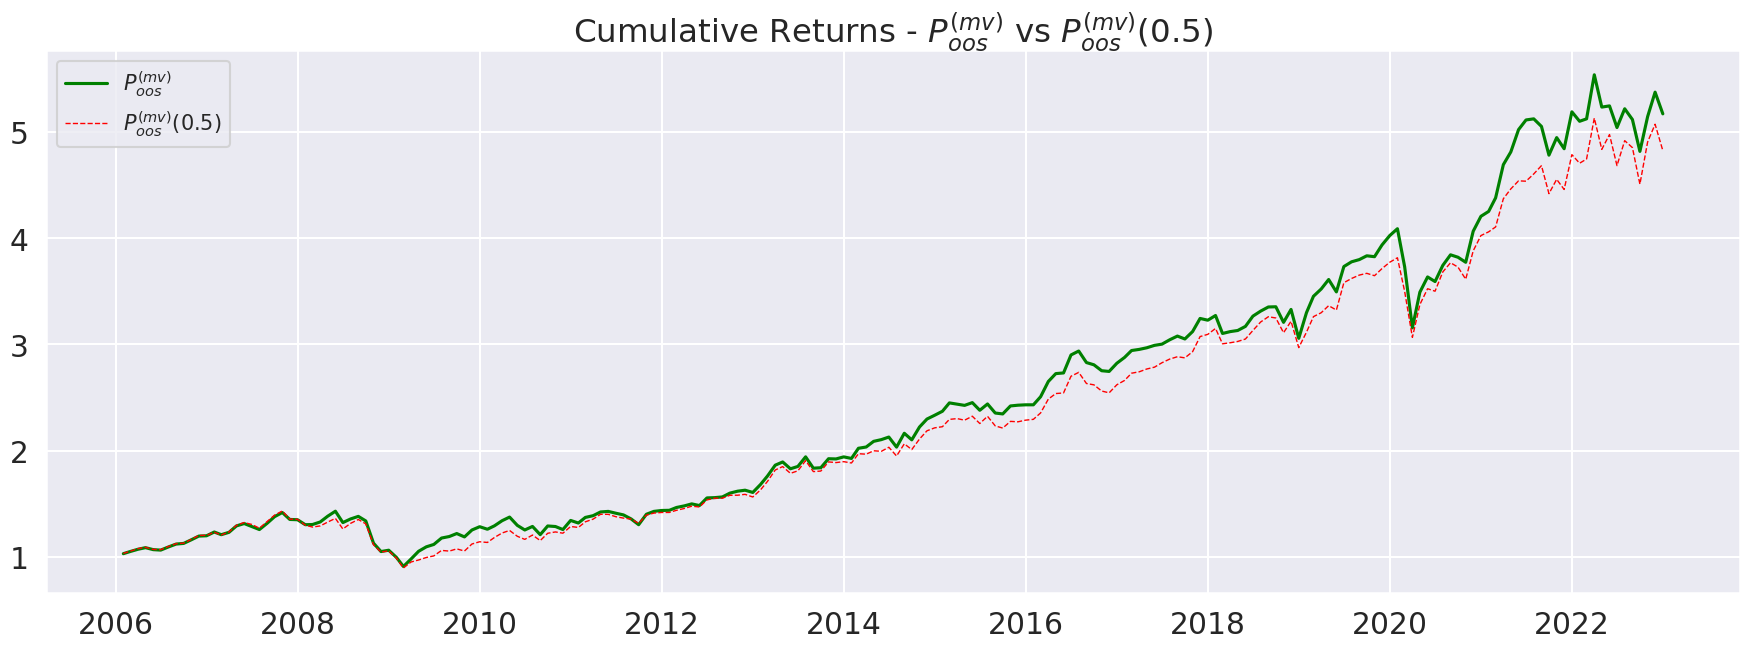

In [39]:
fig, ax = plt.subplots(figsize=(18,7))

portfolio_cumprod = (1 + performances.T).cumprod()
portfolio05_cumprod = (1+performances_df).cumprod()

ax.title.set_text('Cumulative Returns - $P_{oos}^{(mv)}$ vs $P_{oos}^{(mv)}(0.5)$')
ax.plot(portfolio_cumprod, color='green', label="$P_{oos}^{(mv)}$")
ax.plot(portfolio05_cumprod, color='red', label="$P_{oos}^{(mv)}(0.5)$", lw = 1, linestyle='--')
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()

#### 2.3.1  Compute the benchmark portfolio by maximizing the minimum variance criterion for the tracking error every year

$$
\min_{\alpha_Y} \quad (TE_{p,Y})^2 = (\alpha_Y - \alpha_Y^{(vw)})'\Sigma_{Y+1} (\alpha_Y - \alpha_Y^{(vw)})
\\

s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P^{(vw)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [40]:
## Compute the Carbon Footprint of the value-weighted portfolio
capy = mv_y.iloc[:,mv_y.columns.isin(range(2006, 2022+1))].sum()

cfy_vw = pd.DataFrame(columns=['Carbon Footprint'])
for year in range(2006, 2022+1):
    cfy_vw.loc[year] = carbon_em.sum()[year-1] * 1/capy[year]

cfy_vw

,Carbon Footprint
2006,184.533251
2007,184.948169
2008,312.341636
2009,238.290087
2010,193.621450
2011,210.188616
2012,185.583915
2013,144.597648
2014,129.860735
2015,139.552220


In [41]:
## All the weights as of 31 December Y in the same df
mv_yearly_weights = mv_weights.T.copy()
mv_yearly_weights.index = pd.to_datetime(mv_yearly_weights.index)
mv_yearly_weights = mv_yearly_weights.resample('Y').last()
mv_yearly_weights.index = mv_yearly_weights.index.year

In [42]:
## Let's do the optimization
def tracking_error(weights, covmat, year):
    diff = weights - mv_yearly_weights.loc[year]
    return np.dot(diff.T, np.dot(covmat, diff))

def carbon_footprint_constraint2(weights, year, initial_invest):
    if type(weights) != pd.Series:
        weights = pd.Series(weights, index=df_m.columns)
    
    carbonfp = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()
    target = cfy_vw.loc[year].values[0] * 0.5

    return -(carbonfp - target)

In [43]:
initial_invest = 1_000_000
weights_pfvw = pd.DataFrame(index=df_m.columns)
vy_vwpf = pd.DataFrame(index=['Money'])
performances_vwdf = []

for year in range(2006, 2022+1):

    vy_vwpf[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(tracking_error, initial_weights, args=(covmat, year),
                    constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_footprint_constraint2(x, year, initial_invest)}],
                                bounds = [(0, 1)] * 595)

    optimal_weights = result.x

    # Compute the performance in order to find the final value of the portfolio (that will be used to compute the carbon footprint of the next year)
    returns_year = df_m.loc[df_m.index.year == year]

    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = optimal_weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[date-1, stock]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[date-1, :]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))

    ## Ex-post performance calculation
    performances_pf = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for date in range(12):
        performances_pf.iloc[date, :] = alpha_data.iloc[:, date] * returns_year.iloc[date,:]

    performances_pf = performances_pf.sum(axis=1)
    performances_vwdf.append(performances_pf)

    initial_invest = ((1+performances_vwdf[-1]).cumprod() * initial_invest).values[-1]
    weights_pfvw[year] = optimal_weights

performances_vwdf = pd.concat(performances_vwdf)

In [44]:
cfy_vwopt = pd.DataFrame(columns=['Carbon Footprint'])

for year in range(2006, 2022+1):
    weights = weights_pfvw[year]
    initial_invest = vy_vwpf[year-1].values[0]
    cfy_vwopt.loc[year] = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()

cfy_vwopt

,Carbon Footprint
2006,92.266626
2007,92.474085
2008,152.894160
2009,119.145044
2010,96.810725
2011,105.094308
2012,92.791957
2013,72.298824
2014,64.930368
2015,64.770422


In [45]:
portfolio_vw05 = portfolio_characteristics(performances_vwdf, 'Portfolio (VW) 0.5')
pd.concat([portfolio_vw, portfolio_vw05], axis=1)

,Portfolio VW,Portfolio (VW) 0.5
Annualized Average Return,0.103492,0.125528
Annualized Volatility,0.15219,0.154175
Sharpe Ratio,0.610482,0.745556
Minimum,-0.168004,-0.171882
Maximum,0.124161,0.121993
Maximum Drawdown,-0.478136,-0.453711


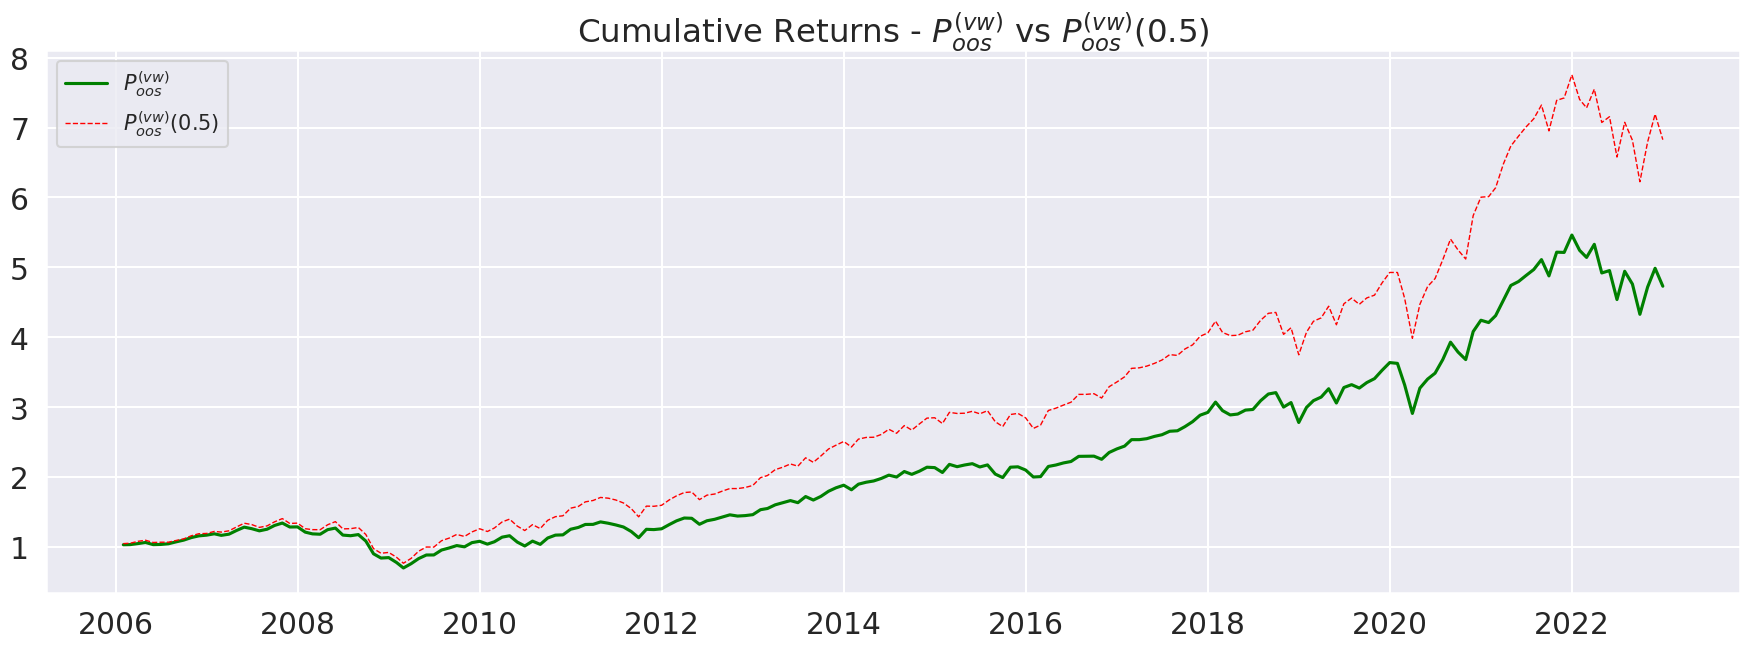

In [46]:
fig, ax = plt.subplots(figsize=(18,7))

portfolio_cumprod = (1 + mv_perf).cumprod()
portfolio05_cumprod = (1+performances_vwdf).cumprod()

ax.title.set_text('Cumulative Returns - $P_{oos}^{(vw)}$ vs $P_{oos}^{(vw)}(0.5)$')
ax.plot(portfolio_cumprod, color='green', label="$P_{oos}^{(vw)}$")
ax.plot(portfolio05_cumprod, color='red', label="$P_{oos}^{(vw)}(0.5)$", lw = 1, linestyle='--')
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()

#### **Part 3 - Allocation with a Net Zero Objective**

##### 3.1 Decarbonization Strategy

$$
CF_Y^{(p)} \le (1-\theta)^{Y-Y_0+1} \ \times \ CF_{Y_0}^{(P^{(vw)})}
$$

In [47]:
## The optimization problem is the same as in point 2.3 expect that the carbon emissions reduction constraint is now defined as above.
def carbon_reduction_constraint(weights, year, initial_invest):
    if type(weights) != pd.Series:
        weights = pd.Series(weights, index=df_m.columns)
    
    carbonfp = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()
    target = cfy_vw.loc[2006].values[0] * ((1-0.10) ** (year-2006+1))

    return -(carbonfp - target)

In [48]:
initial_invest = 1_000_000
weights_nz = pd.DataFrame(index=df_m.columns)
vy_nz = pd.DataFrame(index=['Money'])
performances_nz = []

for year in range(2006, 2022+1):

    vy_nz[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(tracking_error, initial_weights, args=(covmat, year),
                    constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_reduction_constraint(x, year, initial_invest)}],
                                bounds = [(0, 1)] * 595)

    optimal_weights = result.x

    # Compute the performance in order to find the final value of the portfolio (that will be used to compute the carbon footprint of the next year)
    returns_year = df_m.loc[df_m.index.year == year]

    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = optimal_weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[date-1, stock]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[date-1, :]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))

    ## Ex-post performance calculation
    performances_pf = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for date in range(12):
        performances_pf.iloc[date, :] = alpha_data.iloc[:, date] * returns_year.iloc[date,:]

    performances_pf = performances_pf.sum(axis=1)
    performances_nz.append(performances_pf)

    initial_invest = ((1+performances_nz[-1]).cumprod() * initial_invest).values[-1]
    weights_nz[year] = optimal_weights

performances_nz = pd.concat(performances_nz)

In [49]:
cfy_nz = pd.DataFrame(columns=['Carbon Footprint'])

for year in range(2006, 2022+1):
    weights = weights_nz[year]
    initial_invest = vy_nz[year-1].values[0]
    cfy_nz.loc[year] = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()

cfy_nz

,Carbon Footprint
2006,166.079926
2007,149.471933
2008,133.325778
2009,121.072266
2010,108.965040
2011,98.068536
2012,88.261682
2013,79.435514
2014,71.022036
2015,62.728241


In [50]:
portfolio_nz = portfolio_characteristics(performances_nz, 'Portfolio (VW)(NZ)')
pd.concat([portfolio_vw, portfolio_vw05, portfolio_nz], axis=1)

,Portfolio VW,Portfolio (VW) 0.5,Portfolio (VW)(NZ)
Annualized Average Return,0.103492,0.125528,0.125956
Annualized Volatility,0.15219,0.154175,0.154037
Sharpe Ratio,0.610482,0.745556,0.748999
Minimum,-0.168004,-0.171882,-0.17192
Maximum,0.124161,0.121993,0.121992
Maximum Drawdown,-0.478136,-0.453711,-0.452447


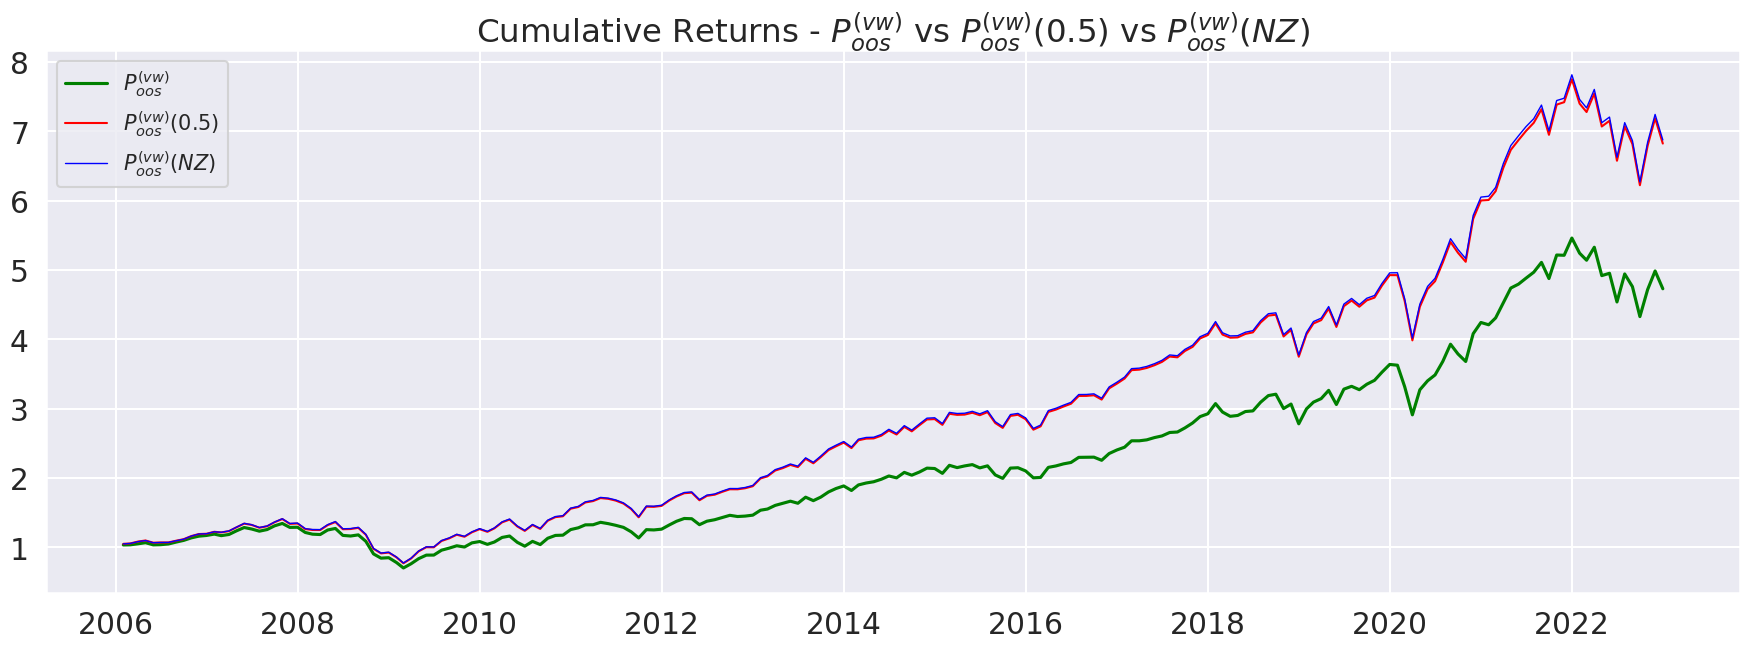

In [78]:
fig, ax = plt.subplots(figsize=(18,7))

bench_cumprod = (1 + mv_perf).cumprod()
portfolio05_cumprod = (1+performances_vwdf).cumprod()
portfolionz_cumprod = (1+performances_nz).cumprod()

ax.title.set_text('Cumulative Returns - $P_{oos}^{(vw)}$ vs $P_{oos}^{(vw)}(0.5)$ vs $P_{oos}^{(vw)}(NZ)$')
ax.plot(bench_cumprod, color='green', label="$P_{oos}^{(vw)}$")
ax.plot(portfolio05_cumprod, color='red', label="$P_{oos}^{(vw)}(0.5)$", lw = 1.5)
ax.plot(portfolionz_cumprod, color='blue', lw=1,  label="$P_{oos}^{(vw)}(NZ)$")
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()